<a name="outline"></a>

## Outline

- [Task 1](#task-1): Neural networks
  - [1.1](#q11) Multi-layer perceptron
  - [1.2](#q12) Convolutional neural network (CNN)
- [Task 2](#task-2): Unsupervised learning
  - [2.1](#q21) Dimensionality reduction and clustering of a subset of  the Fashion-MNIST image data
  - [2.2](#q22) Clustering of the feature matrix
  - [2.3](#q23) Graph-based analysis 


<a name="task-1"></a>
# Task 1: Neural networks [^](#outline)



<a name="q11"></a>

## 1.1 Multi-layer perceptron [^](#outline)



In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

First of all load the data using the codes provided.

In [4]:
def load_data():
  (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
  x_train = x_train.astype('float32') / 255
  x_test = x_test.astype('float32') / 255
  # convert labels to categorical samples
  y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
  y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)
  return ((x_train, y_train), (x_test, y_test))

(x_train, y_train), (x_test, y_test) = load_data()

Initialize the parameters using the Glorot initialization. I wrote a function for this so that the parameters can be initialized every time the model is trained.

In [5]:
def Glorot_init():

  var0 = 2. / (784 + 400)
  W0 = np.random.randn(784, 400) * np.sqrt(var0)
  b0 = np.zeros(400)

  var1 = 2. / (400 + 400)
  W1 = np.random.randn(400, 400) * np.sqrt(var1)
  b1 = np.zeros(400)

  var2 = 2. / (400 + 400)
  W2 = np.random.randn(400, 400) * np.sqrt(var2)
  b2 = np.zeros(400)

  var3 = 2. / (400 + 400)
  W3 = np.random.randn(400, 400) * np.sqrt(var3)
  b3 = np.zeros(400)

  var4 = 2. / (400 + 400)
  W4 = np.random.randn(400, 400) * np.sqrt(var4)
  b4 = np.zeros(400)

  var5 = 2. / (400 + 10)
  W5 = np.random.randn(400, 10) * np.sqrt(var5)
  b5 = np.zeros(10)

  return W0,W1,W2,W3,W4,W5,b0,b1,b2,b3,b4,b5

Write the functions for the dense layers and activations.

In [6]:
def dense(x, W, b):
    
  # x: K x h_in array of inputs
  # W: h_in x h_out array for kernel matrix parameters
  # b: Length h_out 1-D array for bias parameters
  # returns: K x h_out output array 
    
  h = b + x @ W 
  return h

def leaky_relu(h, a=0.01):
    
  # h: K x h_out array of pre-activations
  # returns: K x h_out output array 
    
  return np.maximum(h, a*h)

def softmax(h):
    
  # h: K x h_out array of pre-activations
  # returns: K x h_out output array

  return (np.exp(h)/np.sum(np.exp(h), axis=1).reshape(-1,1))

Write the function to compute the MLP output based on all parameters.

In [7]:
def mlp(x, W0,W1,W2,W3,W4,W5, b0,b1,b2,b3,b4,b5):
    
  # x: K x 28 x 28 array of inputs
  # returns: K x 10 output array 
  
  K = x.shape[0]
  h0 = x.reshape((K,784))
  a1 = dense(h0, W0, b0)
  h1 = leaky_relu(a1)
  a2 = dense(h1, W1, b1)
  h2 = leaky_relu(a2)
  a3 = dense(h2, W2, b2)
  h3 = leaky_relu(a3)
  a4 = dense(h3, W3, b3)
  h4 = leaky_relu(a4)
  a5 = dense(h4, W4, b4)
  h5 = leaky_relu(a5)
  a6 = dense(h5, W5, b5)
  y = softmax(a6)

  return y

Now we wish to compute the output error $\delta^{(k+1)}$ and the derivative for the leaky relu activation. According to the video provided as hints (https://youtu.be/5-rVLSc2XdE), we know that the derivative of the categorical cross entropy with respect to the pre-activations with the softmax function as activation is just a subtraction between the computed output from the model and the true output.

In [8]:
def output_error(y_batch, y):
    
  # y_batch: K x 10 array of true data outputs
  # y: K x 10 array of output post-activations
  # returns: K x 10 array of output errors 
    
  return y - y_batch

In [9]:
def leakyrelu_derivative(ai, a=0.01):
    
  # ai: K x 400 array of hidden layer pre-activations
  # returns: K x 400 array of diagonal elements
    
  derivs = np.ones(ai.shape)
  derivs[ai<0] = a

  return derivs

Below are the functions for computing the loss and accuracy, which will be main output of the training.

In [10]:
def categ_crossentropy(y_true, y_output):
    
  # y_true: K x 10 array of true data outputs
  # y_output: K x 10 array of output
  # returns: scalar of cross entropy loss

  loss = -np.sum(y_true * np.log(y_output))/len(y_true)
    
  return loss

def accuracy(y_true, y_output):
    
  # y_true: K x 10 array of true data outputs
  # y_output: K x 10 array of output
  # returns: scalar of accuracy score

  y_max = np.argmax(y_output, axis=1)

  return np.mean(np.argmax(y_true, axis=1)==y_max)

Now write the function backpropagating from the output errors to hidden layer errors. With this algorithm we could compute the gradient of each parameter.

In [11]:
def backpropagate(delta, W, a):
    
  # delta: K x None array of errors
  # W: Weight matrix
  # a: K x None array of hidden layer pre-activations
  # returns: K x None array of hidden layer errors
    
  delta_back = np.squeeze(leakyrelu_derivative(a)[..., np.newaxis] * W * delta[:, np.newaxis, :])

  return np.sum(delta_back, axis=2)

In [12]:
def grads(delta1,delta2,delta3,delta4,delta5,delta6, h0,h1,h2,h3,h4,h5):
    
    # delta1: K x None array of errors of each layer
    # h1: K x None array of layer post-activations
    # returns: dictionaries of arrays for gradients
    
    grad_W0 = np.mean(delta1[:, np.newaxis, :] * h0[:, :, np.newaxis], axis=0)
    grad_b0 = np.squeeze(np.mean(delta1, axis=0))
    grad_W1 = np.mean(delta2[:, np.newaxis, :] * h1[:, :, np.newaxis], axis=0)
    grad_b1 = np.squeeze(np.mean(delta2, axis=0))
    grad_W2 = np.mean(delta3[:, np.newaxis, :] * h2[:, :, np.newaxis], axis=0)
    grad_b2 = np.squeeze(np.mean(delta3, axis=0))
    grad_W3 = np.mean(delta4[:, np.newaxis, :] * h3[:, :, np.newaxis], axis=0)
    grad_b3 = np.squeeze(np.mean(delta4, axis=0))
    grad_W4 = np.mean(delta5[:, np.newaxis, :] * h4[:, :, np.newaxis], axis=0)
    grad_b4 = np.squeeze(np.mean(delta5, axis=0))
    grad_W5 = np.mean(delta6[:, np.newaxis, :] * h5[:, :, np.newaxis], axis=0)
    grad_b5 = np.squeeze(np.mean(delta6, axis=0))

    W_grad_dict = {
     'grad_W0':grad_W0,
     'grad_W1':grad_W1,
     'grad_W2':grad_W2,
     'grad_W3':grad_W3,
     'grad_W4':grad_W4,
     'grad_W5':grad_W5
    }

    b_grad_dict = {
     'grad_b0':grad_b0,
     'grad_b1':grad_b1,
     'grad_b2':grad_b2,
     'grad_b3':grad_b3,
     'grad_b4':grad_b4,
     'grad_b5':grad_b5
    }
    return W_grad_dict, b_grad_dict

Now we can write the function to train the MLP model.

In [13]:
def train_mlp(x_train, y_train, x_test, y_test, epochs=10, learning_rate=1e-3, batch_size=256, verbose=False):

  # Initialization
  loss_train = []
  loss_test = []
  acc_train = []
  acc_test = []
  W0,W1,W2,W3,W4,W5,b0,b1,b2,b3,b4,b5 = Glorot_init()

  for epoch in range(epochs):

    # shuffle the train data
    p = np.random.permutation(len(x_train))
    x_train = x_train[p]
    y_train = y_train[p]

    batch_num = len(x_train)//batch_size

    for i in range(batch_num+1):
      if i < batch_num:
        x_batch, y_batch = x_train[(i*batch_size):((i+1)*batch_size)], y_train[(i*batch_size):((i+1)*batch_size)]
      # For the last batch with less than 256 samples
      else:
        x_batch, y_batch = x_train[(i*batch_size):], y_train[(i*batch_size):]

      # Forward pass
      K = x_batch.shape[0]
      h0 = x_batch.reshape((K,784))
      a1 = dense(h0, W0, b0)
      h1 = leaky_relu(a1)
      a2 = dense(h1, W1, b1)
      h2 = leaky_relu(a2)
      a3 = dense(h2, W2, b2)
      h3 = leaky_relu(a3)
      a4 = dense(h3, W3, b3)
      h4 = leaky_relu(a4)
      a5 = dense(h4, W4, b4)
      h5 = leaky_relu(a5)
      a6 = dense(h5, W5, b5)
      y = softmax(a6)

      # Backward pass
      delta6 = output_error(y_batch, y)
      delta5 = backpropagate(delta6, W5, a5)
      delta4 = backpropagate(delta5, W4, a4)
      delta3 = backpropagate(delta4, W3, a3)
      delta2 = backpropagate(delta3, W2, a2)
      delta1 = backpropagate(delta2, W1, a1)

      # Gradient descent
      W_grads, b_grads = grads(delta1,delta2,delta3,delta4,delta5,delta6, h0,h1,h2,h3,h4,h5)

      W0 -= learning_rate * W_grads['grad_W0']
      W1 -= learning_rate * W_grads['grad_W1']
      W2 -= learning_rate * W_grads['grad_W2']
      W3 -= learning_rate * W_grads['grad_W3']
      W4 -= learning_rate * W_grads['grad_W4']
      W5 -= learning_rate * W_grads['grad_W5']
      b0 -= learning_rate * b_grads['grad_b0']
      b1 -= learning_rate * b_grads['grad_b1']
      b2 -= learning_rate * b_grads['grad_b2']
      b3 -= learning_rate * b_grads['grad_b3']
      b4 -= learning_rate * b_grads['grad_b4']
      b5 -= learning_rate * b_grads['grad_b5']

    # run MLP with updated parameters
    y_output_train = mlp(x_train, W0,W1,W2,W3,W4,W5, b0,b1,b2,b3,b4,b5)
    y_output_test = mlp(x_test, W0,W1,W2,W3,W4,W5, b0,b1,b2,b3,b4,b5)

    # store loss and accuracy for this epoch
    loss_train.append(categ_crossentropy(y_train, y_output_train))
    acc_train.append(accuracy(y_train, y_output_train))
    loss_test.append(categ_crossentropy(y_test, y_output_test))
    acc_test.append(accuracy(y_test, y_output_test))
    if verbose == True:
      print('epoch:{}, train loss:{}, train acc:{}'.format(
          (epoch+1),categ_crossentropy(y_train, y_output_train),accuracy(y_train, y_output_train)))

  return loss_train, acc_train, loss_test, acc_test


Now train the model on our data and plot the loss and accuracy with respect to epochs. Here I reduced the number of epochs to 10 as the algorithm takes too long for large epochs on my computer. I ran the model for 20 epochs in order to use the same data for discussion in 1.1.3, $i.e.$ the comparison of 10 epochs vs 20 epochs.

In [25]:
loss_train, acc_train, loss_test, acc_test = train_mlp(x_train, y_train, x_test, y_test, epochs=20, verbose=True)

epoch:1, train loss:2.223190878859447, train acc:0.16663333333333333
epoch:2, train loss:2.1279031373061725, train acc:0.3815
epoch:3, train loss:2.0013007809176235, train acc:0.47508333333333336
epoch:4, train loss:1.8281109618342621, train acc:0.5189166666666667
epoch:5, train loss:1.6151807985935127, train acc:0.5445666666666666
epoch:6, train loss:1.4052079801238178, train acc:0.6252666666666666
epoch:7, train loss:1.2357209269881644, train acc:0.6486333333333333
epoch:8, train loss:1.1095076728056372, train acc:0.6620666666666667
epoch:9, train loss:1.0165450319178746, train acc:0.67505
epoch:10, train loss:0.9444982594852634, train acc:0.6843166666666667
epoch:11, train loss:0.889855131802836, train acc:0.7005666666666667
epoch:12, train loss:0.8471759687980566, train acc:0.71035
epoch:13, train loss:0.810962909067211, train acc:0.7226666666666667
epoch:14, train loss:0.7815514576643873, train acc:0.7329
epoch:15, train loss:0.7579384442737062, train acc:0.7390333333333333
epoch:

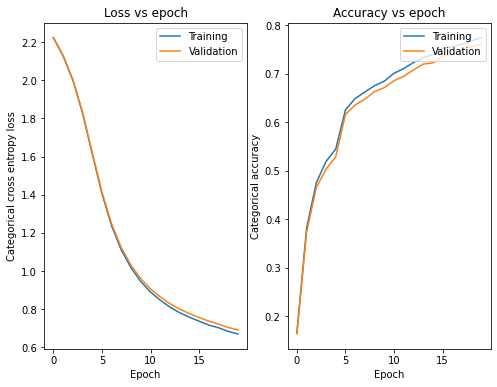

In [37]:
fig = plt.figure(figsize=(8, 6))
fig.add_subplot(121)
plt.plot(loss_train)
plt.plot(loss_test, label='Validation')
plt.xlabel("Epoch")
plt.ylabel("Categorical cross entropy loss")
plt.legend(['Training', 'Validation'], loc='upper right')
plt.title("Loss vs epoch")
fig.add_subplot(122)
plt.plot(acc_train)
plt.plot(acc_test, label='Validation')
plt.xlabel("Epoch")
plt.ylabel("Categorical accuracy")
plt.legend(['Training', 'Validation'], loc='upper right')
plt.title("Accuracy vs epoch")
plt.show()

### 1.1.2

Train the model for learning rate = $10^{-5}$. Note that the model is only run for 10 epochs hence the comparison will be made for the first 10 epochs.

In [28]:
loss_train2, acc_train2, loss_test2, acc_test2 = train_mlp(x_train, y_train, x_test, y_test, epochs=10, learning_rate=1e-5)

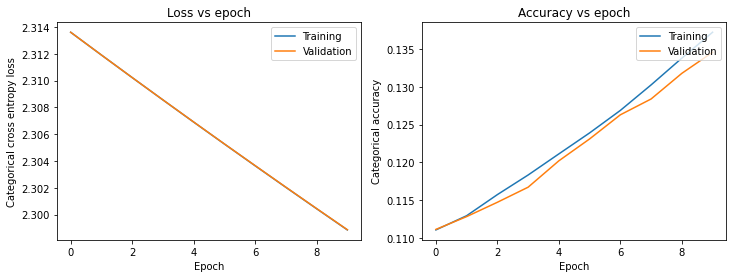

In [41]:
fig = plt.figure(figsize=(12, 4))
fig.add_subplot(121)
plt.plot(loss_train2)
plt.plot(loss_test2, label='Validation')
plt.xlabel("Epoch")
plt.ylabel("Categorical cross entropy loss")
plt.legend(['Training', 'Validation'], loc='upper right')
plt.title("Loss vs epoch")
fig.add_subplot(122)
plt.plot(acc_train2)
plt.plot(acc_test2, label='Validation')
plt.xlabel("Epoch")
plt.ylabel("Categorical accuracy")
plt.legend(['Training', 'Validation'], loc='upper right')
plt.title("Accuracy vs epoch")
plt.show()

We can see that the loss is gradually decreasing with the opposite for accuracy, which is the same trend for model with learning_rate = $10^{-3}$. The performance of the model is stable as the loss and accuracy for both training and validation set improve steadily. Note that the loss curve of validation set even superimposes perfectly with the training set.  However, the convergence is much slower than the previous model, since the loss has only drops for around $0.7$% after 10 epochs, whereas in the previous model the loss has become half of the initial value after 10 epochs.

Now for learning_rate = $0.1$.

In [14]:
loss_train3, acc_train3, loss_test3, acc_test3 = train_mlp(x_train, y_train, x_test, y_test, epochs=10, learning_rate=1e-1)

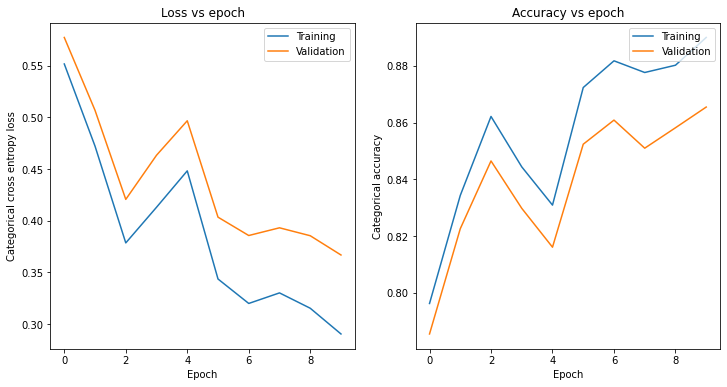

In [15]:
fig = plt.figure(figsize=(12, 6))
fig.add_subplot(121)
plt.plot(loss_train3)
plt.plot(loss_test3, label='Validation')
plt.xlabel("Epoch")
plt.ylabel("Categorical cross entropy loss")
plt.legend(['Training', 'Validation'], loc='upper right')
plt.title("Loss vs epoch")
fig.add_subplot(122)
plt.plot(acc_train3)
plt.plot(acc_test3, label='Validation')
plt.xlabel("Epoch")
plt.ylabel("Categorical accuracy")
plt.legend(['Training', 'Validation'], loc='upper right')
plt.title("Accuracy vs epoch")
plt.show()

We can see that the convergence of the loss(or accuracy) much faster in contrast of the second "slow" model, as the accuracy has already been around 0.8 - 0.9 after 10 epochs and so is for the loss. Yet, the performance of this model is still terrible because the fluctuation of the curves is too big which will result in a large variance of the measures, and the difference between training and validation set is also enlarged.

Combining results of two models we can draw the conclusion that although increasing the learning rate can lead to a faster convergence, the parameters will fluctuate too fiercely to control when it becomes too large.

### 1.1.3

In this subtask we should look at the graph produced in 1.1.1. It is clear that when the number of epochs is increased from 10 to 20, the loss and accuracy improves for both training set and validation set. However, the improvement is less significant when progressing from 10th epoch to 20th epoch compared to progressing from the first epoch to the 10th. This implies that the loss and accuracy is converging, and the parameters are converging to a local minimum(optimal). It can also be observed that the measures for validation set start to be "left behind" by the training set, as the accuracy becomes lower than the training set. This shows that when number of epochs increases, the model will start to overfit the training dataset and the generalizability will reduce.

<a name="q12"></a>
## 1.2 Convolutional neural network (CNN) [^](#outline)

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, LeakyReLU

### 1.2.1

First of all create the model as required.

In [11]:
model = Sequential([
    Conv2D(8, 3, activation=LeakyReLU(alpha=0.01), input_shape=(28, 28, 1)),
    Conv2D(8, 3, activation=LeakyReLU(alpha=0.01)),
    Conv2D(16, 3, activation=LeakyReLU(alpha=0.01)),
    Conv2D(16, 3, activation=LeakyReLU(alpha=0.01)),
    MaxPooling2D(2),
    Flatten(),
    Dense(64, activation=LeakyReLU(alpha=0.01)),
    Dense(10, activation='softmax')
])

Compile the model using the SGD method with the learning rate of $10^{-3}$ and process the dataset.

In [12]:
sgd = tf.keras.optimizers.SGD(learning_rate=0.001)

model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
    
train_dataset = train_dataset.shuffle(1024)
    
train_dataset = train_dataset.batch(256)
test_dataset = test_dataset.batch(256)


Now we can fit the model with data and again plot the loss and accuracy.

In [48]:
history = model.fit(train_dataset, epochs=40, validation_data=test_dataset,  verbose=0)

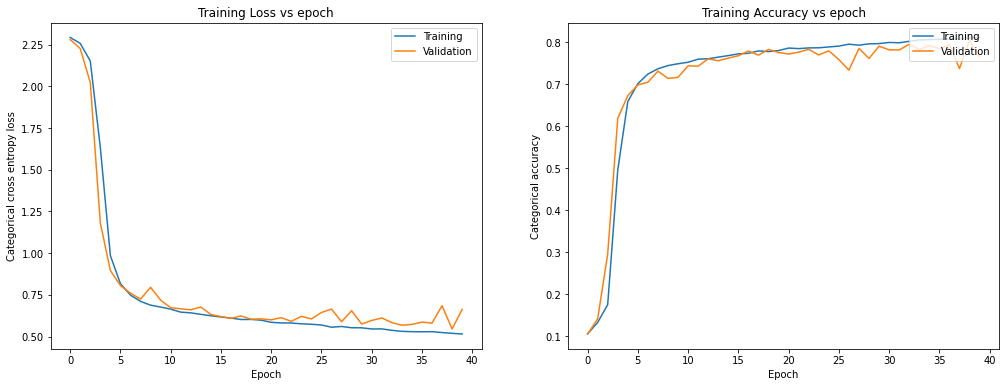

In [50]:
fig = plt.figure(figsize=(17, 6))
fig.add_subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel("Epoch")
plt.ylabel("Categorical cross entropy loss")
plt.legend(['Training', 'Validation'], loc='upper right')
plt.title("Training Loss vs epoch")
fig.add_subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'], label='Validation')
plt.xlabel("Epoch")
plt.ylabel("Categorical accuracy")
plt.legend(['Training', 'Validation'], loc='upper right')
plt.title("Training Accuracy vs epoch")
plt.show()

It can be observed from the plotting that the loss and accuracy converges quite rapidly for both training and validation set with accuracy converging to around 0.8, which is a satisfying result and shows that the model fits the data well. However, the validation set experiences some flutuations towards convergence, which may indicate overfitting of the training data. Comparing to results in 1.1.1 for the first 20 epochs, the trends are very similar, but the values converges slightly faster in CNN model. The flutuation is the main difference.

###  1.2.2

Write the function to create the model with dropout relative to the dropout rate.

In [8]:
from tensorflow.keras.layers import Dropout

def get_dropout_model(rate):

  model = Sequential([
    Conv2D(8, 3, activation=LeakyReLU(alpha=0.01), input_shape=(28, 28, 1)),
    Conv2D(8, 3, activation=LeakyReLU(alpha=0.01)),
    Conv2D(16, 3, activation=LeakyReLU(alpha=0.01)),
    Conv2D(16, 3, activation=LeakyReLU(alpha=0.01)),
    MaxPooling2D(2),
    Flatten(),
    Dense(64, activation=LeakyReLU(alpha=0.01)),
    Dropout(rate),
    Dense(10, activation='softmax')
  ])
  
  return model

In [11]:
# Split train to validation as 80:20
split_rate = 0.8
train_x, val_x = np.split(x_train, [int(split_rate*(x_train.shape[0]))])
train_y, val_y = np.split(y_train, [int(split_rate*(y_train.shape[0]))])

train_dataset2 = tf.data.Dataset.from_tensor_slices((train_x, train_y))
val_dataset = tf.data.Dataset.from_tensor_slices((val_x, val_y))

train_dataset2 = train_dataset2.shuffle(1024)

train_dataset2 = train_dataset2.batch(256)
val_dataset = val_dataset.batch(256)

Write the function to train the model over a range of dropout rates and plot the accuracy relative to the rates. Note that I changed the learning rate of SGD to 0.01 for faster convergence and more precise results, since I only ran the model for 15 epochs for each rate value because the algorithm would take too long otherwise.

In [12]:
rate_vals = np.linspace(0.1,0.9,9)
sgd2 = tf.keras.optimizers.SGD(learning_rate=0.01)

def train_dropout_rate(range):
  
  # returns: array of accuracy values for the dropout rates.

  acc = []
  for rate in range:
    model_for_train = get_dropout_model(rate)
    model_for_train.compile(loss='categorical_crossentropy', optimizer=sgd2, metrics=['accuracy'])
     
    history = model_for_train.fit(train_dataset2, epochs=15, validation_data=val_dataset, verbose=0)
    acc.append(history.history['val_accuracy'][-1])

  return np.array(acc)

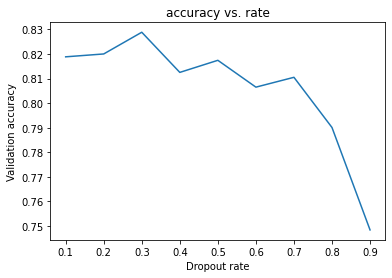

In [12]:
acc_vals2 = train_dropout_rate(rate_vals)

plt.plot(rate_vals, acc_vals2)
plt.title('accuracy vs. rate')
plt.ylabel('Validation accuracy')
plt.xlabel('Dropout rate')
plt.show()

From the plotting we can see that dropout rate = $0.3$ produces the highest validation accuracy, hence it will used as the optimal value.

Now we train the model again on the whole dataset with the optimal dropout rate, switching the SGD method and number of epochs back to the original ones in 1.2.1 for valid comparison.

In [13]:
model_dropout = get_dropout_model(0.3)

model_dropout.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

history_dropout = model_dropout.fit(train_dataset, epochs=40, validation_data=test_dataset,  verbose=0)

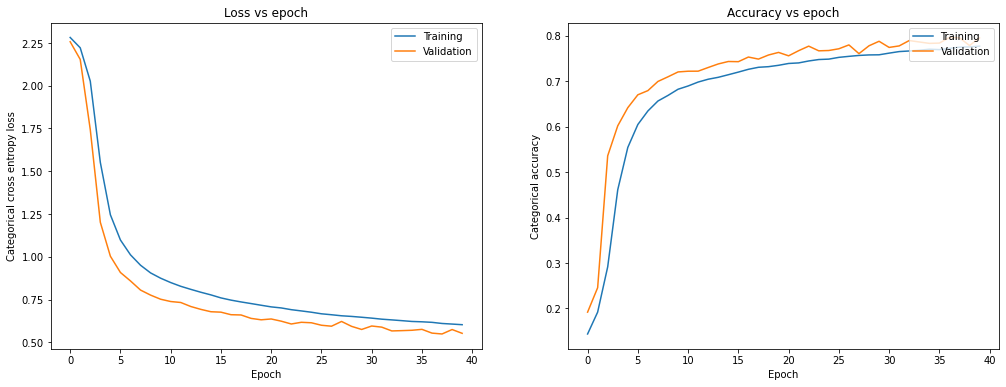

In [17]:
fig = plt.figure(figsize=(17, 6))
fig.add_subplot(121)
plt.plot(history_dropout.history['loss'])
plt.plot(history_dropout.history['val_loss'], label='Validation')
plt.xlabel("Epoch")
plt.ylabel("Categorical cross entropy loss")
plt.legend(['Training', 'Validation'], loc='upper right')
plt.title("Loss vs epoch")
fig.add_subplot(122)
plt.plot(history_dropout.history['accuracy'])
plt.plot(history_dropout.history['val_accuracy'], label='Validation')
plt.xlabel("Epoch")
plt.ylabel("Categorical accuracy")
plt.legend(['Training', 'Validation'], loc='upper right')
plt.title("Accuracy vs epoch")
plt.show()

Again, the trends and convergence of the two features are very similar compared to the model without dropout. It can be seen that the loss and accuracy for the training set in this model is 'worse' than the ones in 1.2.1,  $i.e.$ the loss is higher and the accuracy is lower. This is probably due to the fact that the high dropout rate disregards many of the features(neurons) in the fully connected layer during the training process, which makes it harder to recover the original data used for training. However, the performance of the model on the validation set is still well and the values even surpass the ones in training set. Additionally, the flutuation towards convergence is significantly reduced, meaning that the overfitting is mitigated. This implies that the model with dropout generalizes better to other datasets.

In addition, we can look at the activations in the hidden dense layer.

In [35]:
model_dropout.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 26, 26, 8)         80        
                                                                 
 conv2d_9 (Conv2D)           (None, 24, 24, 8)         584       
                                                                 
 conv2d_10 (Conv2D)          (None, 22, 22, 16)        1168      
                                                                 
 conv2d_11 (Conv2D)          (None, 20, 20, 16)        2320      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 10, 10, 16)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 1600)              0         
                                                      

In [30]:
from tensorflow.keras.models import Model

inputs = model_dropout.inputs
act_features = Model(inputs=inputs, outputs=model_dropout.get_layer('dense_4').output)
activations = act_features(x_test)

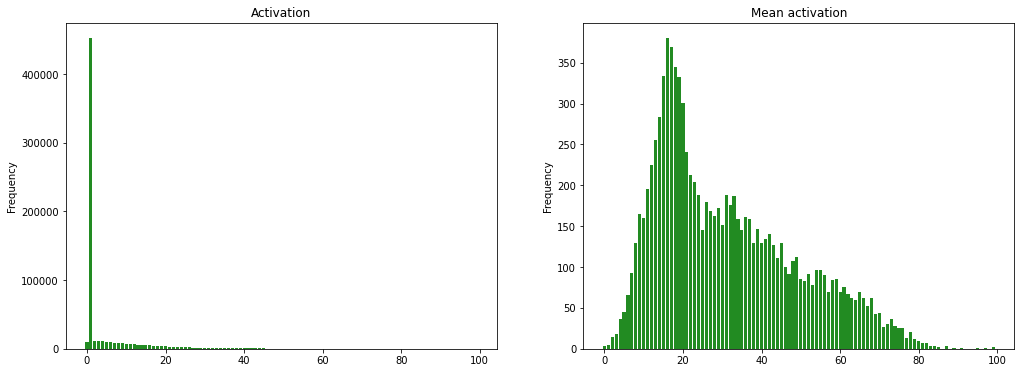

In [36]:
acts_mean = np.mean(activations, axis=1)

hist, edge = np.histogram(activations,bins=100)
hist_mean, edge_mean = np.histogram(acts_mean,bins=100)

fig = plt.figure(figsize=(17, 6))
fig.add_subplot(121)
plt.bar(range(100), hist, align='center', color=['forestgreen'])
plt.ylabel("Frequency")
plt.title("Activation")
fig.add_subplot(122)
plt.bar(range(100), hist_mean, align='center', color=['forestgreen'])
plt.ylabel("Frequency")
plt.title("Mean activation")
plt.show()

It is demonstrated in the activation plot that a massive number of hidden units in the dense layer have activations close to zero and only a few have significant non-zero activations. It shows that the activations are sparse in the fully connected layer, and only the features that does not depend on other neurons are captured. This reduces the effect of intra-correlation of features on the performance of the model, which enables better generalization.

### 1.2.3

Comparing the two accuracy plots up to epoch = $20$, we can see that the accuracy for training set in the dropout CNN model is around 0.73, which is not much lower than the accuracy in the MLP model (reaching 0.8). The difference in the accuracies for the validation set is further reduced. However, the CNN model only has $107266$ parameters according to the model summary, while the MLP model has a total of $784*400+400^2*4+400*5+10=959610$ parameters which is much more. Hence the MLP model produces higher accuracy due to the enormous number of parameters, but the CNN model is able to dramatically reduce the number of parameters while maintaining a good performance on accuracy.

### 1.2.4

Set up the codes for plotting the images of feature maps. Note that since I did not name the layers in the Sequential structure for the model, the layer names change everytime the get_dropout_model function is run. The layer_names below matche the ones in the model summary above, but they shall be changed when a new model is created.

In [28]:
inputs = model_dropout.inputs
layer_names = ['conv2d_8', 'conv2d_9', 'conv2d_10', 'conv2d_11']
outputs = [model_dropout.get_layer(layer_name).output for layer_name in layer_names]
dropout_features = Model(inputs=inputs, outputs=outputs)

In [30]:
image = x_test[0]

# generate dataset for the features along with the original image
features = dropout_features(image[tf.newaxis, ...])
features = [image] + features

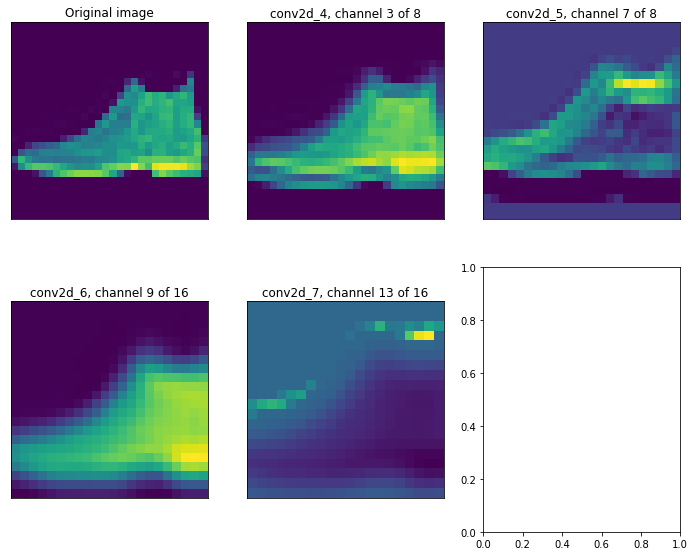

In [39]:
import numpy as np

n_rows, n_cols = 2, 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 10))
fig.subplots_adjust(hspace=0.05, wspace=0.2)

for i in range(len(features)):
    feature_map = features[i]
    num_channels = feature_map.shape[-1]
    row = i // n_cols
    col = i % n_cols
    if i == 0:
        axes[row, col].imshow(image)
        axes[row, col].set_title('Original image')
    else:
        random_feature = np.random.choice(num_channels)
        axes[row, col].imshow(feature_map[0, ..., random_feature])
        axes[row, col].set_title('{}, channel {} of {}'.format(layer_names[i-1], random_feature + 1, num_channels))
        
    axes[row, col].get_xaxis().set_visible(False)
    axes[row, col].get_yaxis().set_visible(False)
plt.show()

Firstly note that the layer names in the titles of images are different from those written in above because the image is produced using the model before the one who generates the summary (I ran the same model for several times due to disconnection of Google Colab), but the ordering is the same.

It is clear that as the layer 'deepens', the features become harder to intepret. The layer "conv2d_4" seems to concentrate on the interior of the image and "conv2d_5" seems to focus on the concavity of the shoe mouth, whereas no significant features can be intepreted in the latter two layers. Note that only one channel in each layer is selected hence the real features being captured might not be the cases discussed above.

<a name="task-2"></a>

# Task 2: Unsupervised learning [^](#outline)

<a name="q21"></a>

## 2.1 Dimensionality reduction and clustering of a subset of  the Fashion-MNIST image data [^](#outline)

### 2.1.1

Extract the data and normalize it.

In [81]:
x_for_unsup = x_train[:1000]
y_for_unsup = y_train[:1000]

X = x_for_unsup.reshape(-1,28*28)
classes = np.argmax(y_for_unsup, axis=1)

In [7]:
def standardise(X):
    mu = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    std_filled = std.copy()
    std_filled[std==0] = 1.
    Xbar = ((X-mu)/std_filled)
    return Xbar

In [82]:
X = standardise(X)

Now prepare the function of performing PCA for the subsequent tasks.

In [4]:
from scipy.sparse import linalg

def pca_function(X,m):
    '''
    Args:
        X: matrix with shape (N,D) of input data
        m: number of principle components wanted
    Returns:
        X_pca: data after PCA process
        eigenvectors: array of eigenvectors of the covariance matrix
        eigenvalues: array of eigenvalues
    '''

    # create covariance matrix C
    C = 1.0/(len(X)-1) * np.dot(X.T, X)


    # compute eigenvalues and eigenvectors using the eigsh scipy function
    eigenvalues, eigenvectors = linalg.eigsh(C, m, which="LM", return_eigenvectors=True) 

    # sorting the eigenvectors and eigenvalues from largest to smallest eigenvalue
    sorted_index = np.argsort(eigenvalues)[::-1]
    eigenvalues=eigenvalues[sorted_index]
    eigenvectors=eigenvectors[:,sorted_index ]

    X_pca = X.dot(eigenvectors)

    return X_pca, eigenvectors, eigenvalues



### 2.1.2

In [14]:
X_pca, eigvecs, eigvals = pca_function(X,25)

Write the functions to compute the cumulative explained variance of the dimensions. As the explained variance is simply the eigenvalues rescaled, hence we will plot the cumulative sum instead.

In [16]:
def cumulative_explained_variance(X, eigvals):
  
  C = 1.0/(len(X)-1) * np.dot(X.T, X)
  all_eigenvalues, _ = np.linalg.eig(C)
  total_variance = abs(all_eigenvalues.sum())

  explained_variances = eigvals /  total_variance

  cumulative_var = explained_variances.copy()

  for i in range(len(eigvals)):
    if i > 0:
      cumulative_var[i] += cumulative_var[i-1]
  
  return explained_variances, cumulative_var

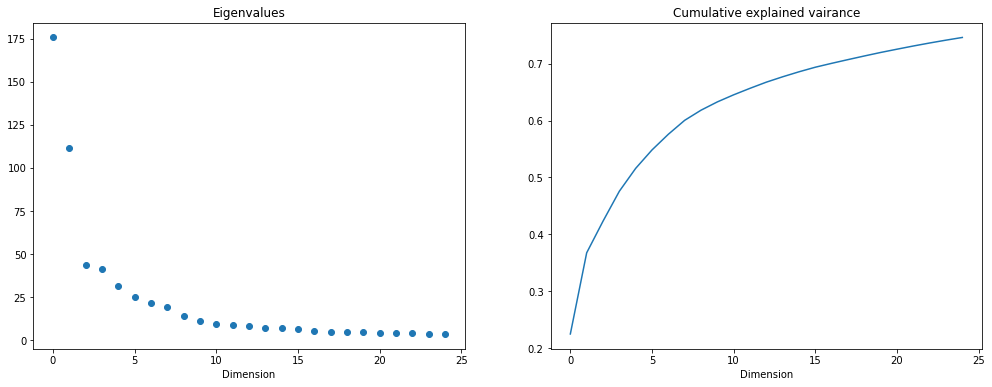

In [92]:
e_var, c_var = cumulative_explained_variance(X, eigvals)

fig = plt.figure(figsize=(17, 6))
fig.add_subplot(121)
plt.scatter(range(len(eigvals)), eigvals)
plt.xlabel("Dimension")
plt.title("Eigenvalues")
fig.add_subplot(122)
plt.plot(c_var)
plt.xlabel("Dimension")
plt.title("Cumulative explained vairance")
plt.show()

We can see from the eigenvalues plot that the first two eigenvalues are much larger with a drastic drop from the second one to the third, and the value gradually decreases after that. The conclusion drawn from this plot that the optimal $m$ would be $2$. However, looking at the curve of cumulative explained variance, the value do not reach 80% even when $m=25$, where 80% is the ideal theshold for determining the dimension according to the lecture notes $p.118$. Therefore, if using the cumulative variance as the criterion the optimal reduced dimension will go over $25$.

In general, $m=2$ is still a reasonable choice to intepret the images on a 2D plane.

### 2.1.3

In [87]:
X_pca2, eigvecs2, eigvals2 = pca_function(X,2)

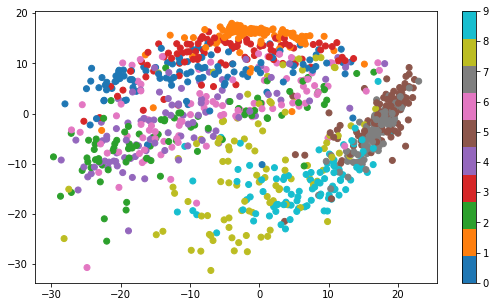

In [88]:
plt.figure(figsize=(9,5))
plt.scatter(X_pca2[:,0],X_pca2[:,1], c=classes, cmap='tab10')
plt.colorbar()
plt.show()

From the scatter plot we can see a general trend of grouping of points within the same class. This is particularly significant for a few classes, for instance, the grey class "7", cyan "9", orange "1"; whereas some other classes are more spread out and involve overlapping with other classes, for example, the pink "6" and violet "4". This means that the PCA process fail to distinguish these classes by only two pricinple components.

### 2.1.4

The codes for k_means clustering function here is modified to include the value of within cluster distance $W(C,k)$ as a return argument.

In [122]:
def k_means(X, k, max_iter=50):
  
  n_samples, n_features = X.shape

  # labels: assign every sample to a cluster at random
  np.random.seed(123)
  labels = np.random.randint(low=0, high=k, size=n_samples)
  X_labels = np.append(X, labels.reshape(-1,1), axis=1)

  # computing the centroids of each of the k clusters
  centroids = np.zeros((k, n_features))
  for i in range(k):
      centroids[i] = np.mean([x for x in X_labels if x[-1]==i], axis=0)[0:n_features]

  new_labels = np.zeros(len(X))
  difference = 0

  # k-means algorithm
  for i in range(max_iter):
      # distances: between data points and centroids
      distances = np.array([np.linalg.norm(X - c, axis=1) for c in centroids])
      # new_labels: computed by finding centroid with minimal distance
      new_labels = np.argmin(distances, axis=0)

      if (labels==new_labels).all():
          # labels unchanged
          labels = new_labels
          break
      else:
          # labels changed
          # difference: percentage of changed labels
          difference = np.mean(labels!=new_labels)  
          labels = new_labels
          for c in range(k):
              # update centroids by taking the mean over associated data points
              if (labels == c).any():
                  centroids[c] = np.mean(X[labels==c], axis=0)           
      
  # Compute W(C,k)
  W = 0
  for i, c in enumerate(centroids):
      X_c = X[labels==i]
      centroid_dist = np.sum(np.linalg.norm(X_c - c, axis=1))
      W += centroid_dist

  return labels, centroids, W

Below I presented plots of PCA spaces for all values of $k$.

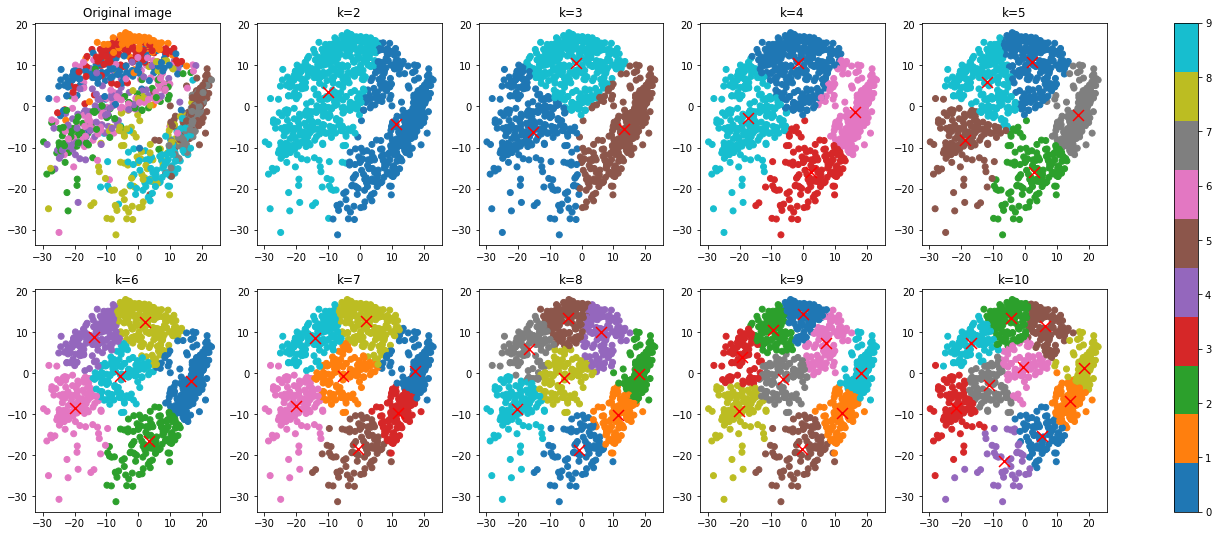

In [140]:
k_vals = np.arange(2,11)

n_rows, n_cols = 2, 5
fig, axes2 = plt.subplots(n_rows, n_cols, figsize=(24, 9))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

im = axes2[0,0].scatter(X_pca2[:,0],X_pca2[:,1], c=classes, cmap='tab10')
axes2[0, 0].set_title('Original image')
fig.colorbar(im, ax=axes2)

W_list = np.zeros(9)
for k in k_vals:

    row = (k-1) // n_cols
    col = (k-1) % n_cols

    labs, cens, W = k_means(X_pca2, k)
    W_list[k-2] = W

    im = axes2[row, col].scatter(X_pca2[:,0], X_pca2[:,1], c=labs, cmap='tab10')
    axes2[row, col].scatter(cens[:, 0], cens[:, 1], c='red', marker='x', s=120)
    axes2[row, col].set_title('k={}'.format(k))
        
plt.show()

We can see it is hard to determine the optimal $k$ by the PCA spaces, hence we need to plot $W(C,k)$.

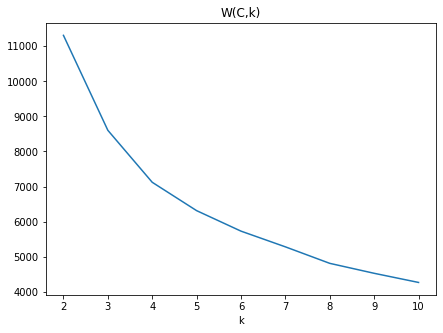

In [139]:
plt.figure(figsize=(7,5))
plt.plot(k_vals, W_list)
plt.xlabel("k")
plt.title("W(C,k)")
plt.show()

According to lecture notes $p.109$, the optimal $k$ is at the "elbow" of the curve, which is approximately $k=4$ in the curve above as the improvement of $W$ is less significant since that point. Hence the optimal $k$ differs from the true number of classes.

<a name="q22"></a>

## 2.2 Clustering of the feature matrix [^](#outline)

In [4]:
F = np.load('dolphins_F_62x32.npy')

### 2.2.1

In [5]:
def euclid_distances(points):
    '''
    Args:
        points: A numpy array of points having the shape (N, D), 
          where N is the number of points and D is the number of features.
    Returns:
        A numpy array with shape (N, N) such that the element (i, j) is the computed
        distance between i-th point and j-th point in X.
    '''
    N, D = points.shape
    distance = np.empty((N, N))
    
    # distance matrix will be symmetric, so avoid redundant computations.
    for i in range(N):
        distance[i, i] = 0
        for j in range(i + 1, N):
            d = np.sqrt(np.power(points[i, :] - points[j, :], 2).sum())   
            distance[i, j] = d
            distance[j, i] = d
            
    return distance

In [6]:
d = euclid_distances(F)

In [7]:
def average_linkage(distances, cluster_assignment, i, j):
    """
    This function computes the average linkage value between two clusters.
    Args:
      distances: A numpy array of pair-wise distances for the given points.
      cluster_assignment: A 1-D numpy array that assigns a cluster id for every point.
      i: the first cluster id.
      j: the second cluster id.
    Returns:
      The average distance between the two given clusters.
    """
    # Select the point indices of the first cluster.
    points_i = np.argwhere(cluster_assignment == i)
    # Select the point indices of the second cluster.
    points_j = np.argwhere(cluster_assignment == j)
    # Form a cartesian product between the indices in i and indices in j.
    pairs = np.array([[element_i.item(), element_j.item()]  for element_i in points_i for element_j in points_j])
    # Select the pair distances between the points in the two clusters from the distances matrix.
    pairs_distance = distances[pairs[:, 0], pairs[:, 1]]
    # Return the average
    return pairs_distance.mean()

In [8]:
def hierarchical_clustering(points, distances, linkage):
    """
    The hierarchical clustering algorithm start with every point as a single cluster and 
    each iteration merges two clusters into one. We may wish to store all the 
    intermediate clustering results with respect to the number of clusters left.

    Args:
     points: A numpy array of points having the shape (N, D), 
          where N is the number of points and D is the number of features.
     distances: A numpy array with shape (N, N) such that the element (i, j) is the computed
        distance between i-th point and j-th point in X.
     linkage: A linkage function from the above to call to compute the linkage values between two clusters.

    Returns:
     A numpy array of shape (N, N) of which each row stores the clustering assignment at each level.
     The first row, i.e. a[0, :], represents the points assigned into N cluster indices, i.e. every point as it own cluster
     The last row, i.e. a[N - 1, :], represents the highest level of clustering where all columns have the same index value.
    """ 
    N, D = points.shape
    assignments = np.zeros((N, N))
    
    # Begin with every point is its own cluster
    current_assignment = np.arange(N)
    
    assignments[-1, :] = current_assignment
    # The id to be assigned for the next merged cluster
    next_cluster_id = N
    
    # Begin from level (N - 1) to level 1
    for level in range(N - 1, 0, -1):
        if (level % 10) == 0:
            print(f'level:{level}')
        cluster_ids = np.unique(current_assignment)
        
        min_d = np.inf
        
        # Initialize the cluster ids to be merged in this iteration.
        cluster_a, cluster_b = (-1, -1) 
        
        # Now find the two clusters that have the minimum distance in between.
        for i in range(cluster_ids.size):
            for j in range(i + 1, cluster_ids.size):
                cluster_i = cluster_ids[i]
                cluster_j = cluster_ids[j]
                d = linkage(distances, current_assignment, cluster_i, cluster_j)    ## <-- EDIT THIS LINE
                if d < min_d:
                    min_d = d
                    cluster_a, cluster_b = (cluster_i, cluster_j)
                    
        
        # Merge the two clusters
        current_assignment[(current_assignment == cluster_a) | (current_assignment == cluster_b)] = next_cluster_id
        next_cluster_id += 1
        # Store the current cluster assignment into the assignments array.
        assignments[(level-1), :] = current_assignment
        
    return assignments[::-1]

In [9]:
hc = hierarchical_clustering(F, d, average_linkage)

level:60
level:50
level:40
level:30
level:20
level:10


Below are the print for the sequence of clusters presented in rows. The codes are slightly modified so that the first row is the "finest" cluster where each point stands for its own cluster and the last row is the "coarsest" with only one cluster.

In [10]:
np.set_printoptions(threshold=np.inf)

print(hc)

[[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
   14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
   28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
   42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
   56.  57.  58.  59.  60.  61.]
 [  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
   14.  15.  16.  17.  18.  19.  20.  21.  62.  23.  24.  25.  26.  27.
   28.  29.  30.  62.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
   42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
   56.  57.  58.  59.  60.  61.]
 [  0.   1.   2.   3.  63.   5.   6.   7.   8.   9.  10.  63.  12.  13.
   14.  15.  16.  17.  18.  19.  20.  21.  62.  23.  24.  25.  26.  27.
   28.  29.  30.  62.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
   42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
   56.  57.  58.  59.  60.  61.]
 [  0.   1.   2.   3.  63.   5.   6. 

### 2.2.2

In [36]:
def d_1(points, clusters):
    """
    Args:
     points: A numpy array of points having the shape (N, D), 
          where N is the number of points and D is the number of features.
     clusters: A 1-D array of the assignments of the points into their clusters.

    Returns:
     A 1-D array of the mean distance between each point and the points in the same cluster with it.
    """ 
    N, D = points.shape
    d1 = np.zeros(N)
    for i in range(N):
      sample = points[i]
      same_cluster = points[clusters==clusters[i]]
      # Consider only the clusters with size larger than 1
      if len(same_cluster) > 1:
        d = np.sum(np.sqrt(np.sum(np.power(sample - same_cluster, 2), axis=1)))
        d1[i] = d/(len(same_cluster)-1)

    return d1

def d_2(points, clusters):
    """
    Args:
     points: A numpy array of points having the shape (N, D), 
          where N is the number of points and D is the number of features.
     clusters: A 1-D array of the assignments of the points into their clusters.

    Returns:
     A 1-D array of the mean distance between each point and the points in the nearest cluster.
    """ 
    N, D = points.shape
    cluster_id = np.unique(clusters)

    d2 = np.zeros(N)
    
    # Exclude the situation where there is only one cluster
    if len(cluster_id) > 1:
      for i in range(N):
        sample = points[i]
        d_list = []
        for c in cluster_id:
          if c != clusters[i]:
            cluster = points[clusters==c]
            d = np.mean(np.sqrt(np.sum(np.power(sample - cluster, 2), axis=1)))
            d_list.append(d)
          
        # the cluster with minimum distance to the point is the nearest
        min_d = np.amin(np.array(d_list))

        d2[i] = min_d

    return d2

In [63]:
def silhouette_score(points, clusters):
    """
    Returns:
     The silhoutte score as an integer.
    """ 
    cluster_id = np.unique(clusters)
    
    if len(cluster_id) == 1:
      raise ValueError('number of clusters must be at least 2')

    else:
      d1 = d_1(points, clusters)
      d2 = d_2(points, clusters)

      # setting the silhouette coeff of the clusters with 1 element to zero
      non_zero = np.argwhere(d1)
      d1 = d1[non_zero]
      d2 = d2[non_zero]

      ss = np.sum((d2 - d1)/np.maximum(d1, d2))/points.shape[0]
    return ss

Here I did not computed the silhouette scores for the first and last clustering as they are trivial, therefore the score starts from level(2) and ends at level(61).

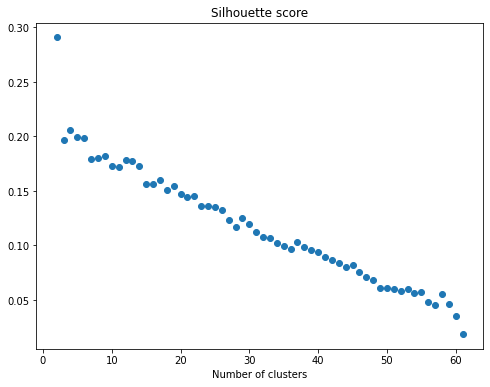

In [64]:
ss = np.zeros(len(hc)-2)
for i in range(len(hc)-2):
  ss[i] = silhouette_score(F, hc[i+1])

plt.figure(figsize=(8,6))
plt.scatter(np.arange(2,62), ss[::-1])
plt.xlabel("Number of clusters")
plt.title("Silhouette score")
plt.show()

We can see from the plot that level(2) possesses the highest silhouette score, hence it is optimal to use 2 clusters to cluster the feature matrix.

<a name="q23"></a>

## 2.3 Graph-based analysis  [^](#outline)

In [20]:
from scipy.sparse import linalg

A = np.load('dolphins_A_62x62.npy')

### 2.3.1

In [3]:
def norm_laplacian(A):

  # define diagonal matrix of node degrees
  weighted_degree = A.sum(axis=1)

  # computing inverse square root vector of degree
  weighted_degree_sqrt = 1.0 / np.sqrt(weighted_degree)

  # set a diagonal matrix of the inverse square root of degree
  D_inv_sqrt = np.diag(weighted_degree_sqrt)

  # define the normalised Laplacian
  L_norm = np.eye(A.shape[0]) - D_inv_sqrt.dot(A.dot(D_inv_sqrt))

  return L_norm

In [20]:
L_norm = norm_laplacian(A)

# return the smallest magnitude eigenvectors and eigenvalues
eigenvals, eigenvecs = linalg.eigsh(L_norm, 2, which="SM", return_eigenvectors=True)

print('The first eigenalue is: {}'.format(eigenvals[0]))
print('The second eigenalue is: {}'.format(eigenvals[1]))

The first eigenalue is: 6.235198121918567e-17
The second eigenalue is: 0.03952455375743451


Note that first eigenvalue is supposed to be 0 with the eigenvector $\mathbf{1}$, the printed result has a minute difference due to the precision errors. We need the second smallest eigenvector $i.e.$ the $\mathit{Fiedler}$ eigenvector to partition the graph.

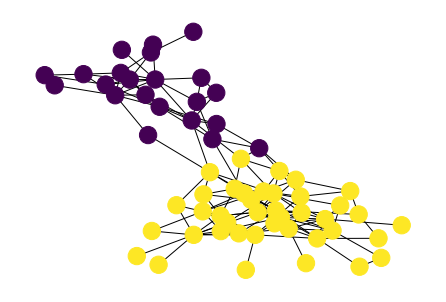

In [23]:
import networkx as nx

fiedler_eigenvector = eigenvecs[:,1]

g = nx.Graph(A)

# define a partition and binarize the negative and positive eigenvector values
spectral_partition = fiedler_eigenvector.copy()
spectral_partition[spectral_partition<0] = 0 
spectral_partition[spectral_partition>0] = 1 

# draw the spectral partition
nx.draw(g, node_color=spectral_partition)

### 2.3.2

In [21]:
def pagerank(A, alpha=0.85):
  
    weighted_degree = A.sum(axis=1)
    D = np.diag(weighted_degree)
    N = A.shape[0]

    # compute pagerank by solving the stationary equation
    M = np.identity(N)-alpha*A@np.linalg.inv(D)
    E = (1-alpha)*np.ones(N).reshape(-1,1)/N
    PR = np.linalg.solve(M,E)

    return PR

def degree_centrality(A):
    
    degree = A.sum(axis=1)
    
    dc = degree/np.sum(degree)
    
    return dc

def eigenvector_centrality(A):
    
    eigenvalue, eigenvector = linalg.eigsh(A, 1, which="LM", return_eigenvectors=True)
    
    return np.absolute(eigenvector)

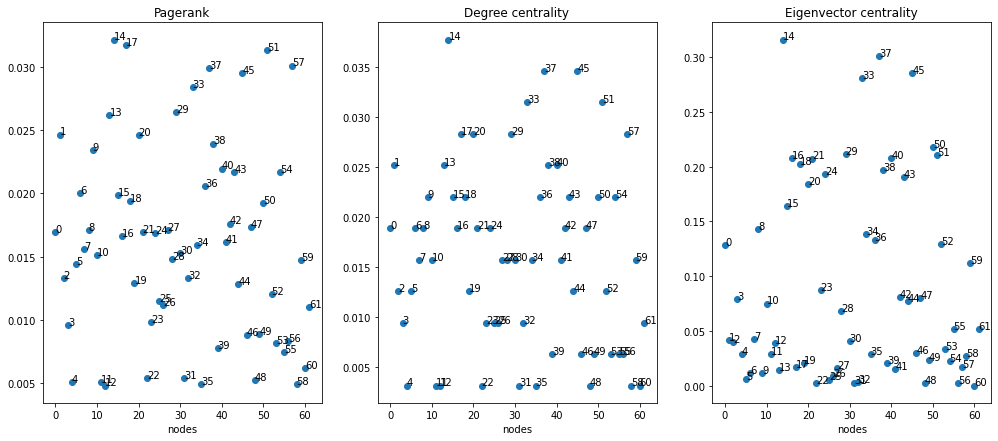

In [22]:
pr = pagerank(A)
dc = degree_centrality(A)
ec = eigenvector_centrality(A)

n_rows, n_cols = 1, 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(17, 7))
fig.subplots_adjust(hspace=0.05, wspace=0.2)

axes[0].scatter(range(62),pr)
axes[0].set_xlabel('nodes')
axes[0].set_title('Pagerank')
for i in range(62):
    axes[0].annotate(i, (i,pr[i]))

axes[1].scatter(range(62),dc)
axes[1].set_xlabel('nodes')
axes[1].set_title('Degree centrality')
for i in range(62):
    axes[1].annotate(i, (i,dc[i]))

axes[2].scatter(range(62),ec)
axes[2].set_xlabel('nodes')
axes[2].set_title('Eigenvector centrality')
for i in range(62):
    axes[2].annotate(i, (i,ec[i]))

plt.show()

Above are the scatter plots of the three centrality measures for all nodes with labels. We can see that the overall pattern is similar, where the nodes "14", "33, "37" and "45" give high values in all three measures hence can be considered as "highly central". But we still the correlation plots to see if there are correlations between the centralities. 

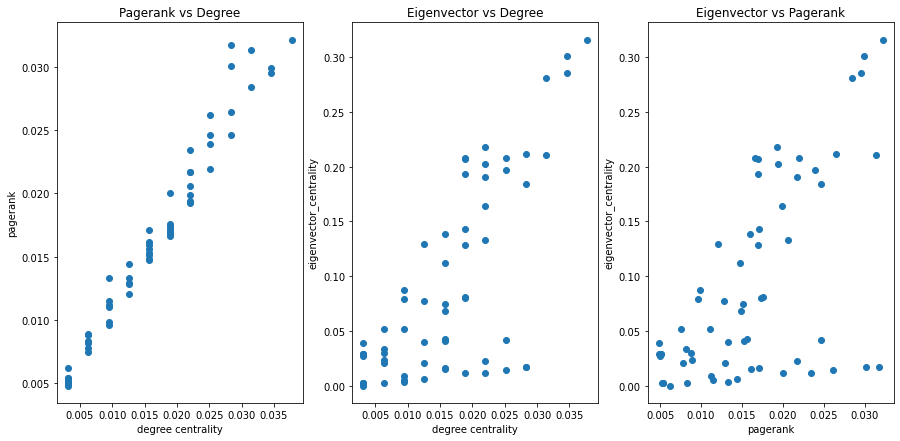

In [23]:
n_rows, n_cols = 1, 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 7))
fig.subplots_adjust(hspace=0.05, wspace=0.2)

axes[0].scatter(dc,pr)
axes[0].set_xlabel('degree centrality')
axes[0].set_ylabel('pagerank')
axes[0].set_title('Pagerank vs Degree')

axes[1].scatter(dc,ec)
axes[1].set_xlabel('degree centrality')
axes[1].set_ylabel('eigenvector_centrality')
axes[1].set_title('Eigenvector vs Degree')

axes[2].scatter(pr,ec)
axes[2].set_xlabel('pagerank')
axes[2].set_ylabel('eigenvector_centrality')
axes[2].set_title('Eigenvector vs Pagerank')


plt.show()

In these figures it becomes clear that there is a strong positive linear correlation between the degree centrality and the pagerank centrality, that is to say, a node with high degree centrality will also tend to have high pagerank centrality. As for the eigenvector centrality, at most of the nodes it is positively correlated with the other two, but with a few exceptions where the eigenvector centrality gives a low ranking while the other two measures disagree. This might be due to the feature that eigenvector centrality is capturing, $i.e.$ the node might have a high degree but is not connected to any of other highly central nodes.

In [25]:
import pandas as pd

names = pd.read_csv('dolphin_names.csv')
names = names.to_numpy()

Here I selected the dolphins mentioned in the above discussion for having high centrality in all measures, but I also pointed out two dolphins who have high degree and pagerank centralities but insignificant eigenvector centrality.

In [26]:

name_list = [item[1] for item in names]

print('The most central dolphins for both 3 centralities: {}, {}, {}, {}'.format(
    name_list[14],name_list[33],name_list[37],name_list[45]))
print('The dolphin signicant in degree & Pagerank: {}, {}'.format(name_list[51],name_list[57]))

The most central dolphins for both 3 centralities: Grin, Scabs, SN4, Topless
The dolphin signicant in degree & Pagerank: Trigger, Web


According to the original paper by Lusseau $\mathit{et}$ $\mathit{al}$, there are three groups of network among the dolphins. $\mathit{Jonah}$ and $\mathit{Topless}$ are centered in the first group among which $\mathit{Topless}$ is spotted by the centrality algorithm; $\mathit{Gallatin}$ is the central individual for group 2 but it can be seen from $\mathbf{Fig.5}$ in the paper that $\mathit{Web}$ also has many associations, who happens to have high degree and pagerank centrality; $\mathit{Srabs}$ holds the central position in the last group, who is again significant in terms of all types of centralities. It is worth pointing out that $\mathit{Trigger}$ was referred in the article as "seems to have a central position between group 2 and 3", and this feature is also captured. 

In conclusion, the centrality results have well captured the grouping and central individuals in the original paper.